In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [25]:
def fetch_commodity_data(ticker, start_date, end_date):
    """
    Fetches historical data for a commodity.

    :param ticker: Ticker symbol for the commodity.
    :param start_date: Start date for the data.
    :param end_date: End date for the data.
    :return: DataFrame with historical data.
    """
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Example: Fetching historical data for crude oil
commodity_ticker = 'CL=F'  # Crude oil futures
commodity_data = fetch_commodity_data(commodity_ticker, '2010-01-01', '2020-12-31')
commodity_data.sort_index(inplace=True)
# Display the first few rows of data
print(commodity_data.head())


[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2010-01-04  79.629997  81.680000  79.629997  81.510002  81.510002  263542
2010-01-05  81.629997  82.000000  80.949997  81.769997  81.769997  258887
2010-01-06  81.430000  83.519997  80.849998  83.180000  83.180000  370059
2010-01-07  83.199997  83.360001  82.260002  82.660004  82.660004  246632
2010-01-08  82.650002  83.470001  81.800003  82.750000  82.750000  310377


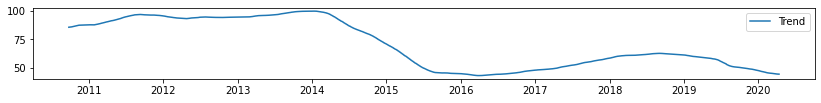

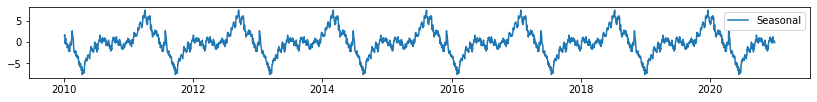

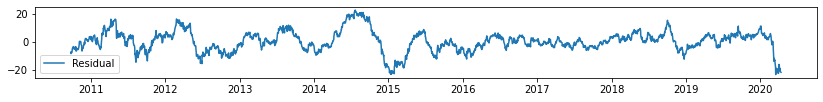

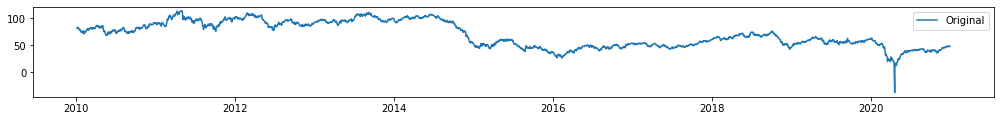

In [49]:
# Decompose the time series data to identify seasonality
decomposition = seasonal_decompose(commodity_data['Close'], model='additive', period=365)
# Set the figure size
# Trend Component
plt.figure(figsize=(14, 6))  # Set figure size
plt.subplot(411)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')

# Seasonal Component
plt.figure(figsize=(14, 6))  # Set figure size
plt.subplot(412)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='best')

# Residual Component
plt.figure(figsize=(14, 6))  # Set figure size
plt.subplot(413)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='best')

# Original Data
plt.figure(figsize=(14, 6))  # Set figure size
plt.subplot(414)
plt.plot(commodity_data['Close'], label='Original')
plt.legend(loc='best')

plt.tight_layout()
plt.show()



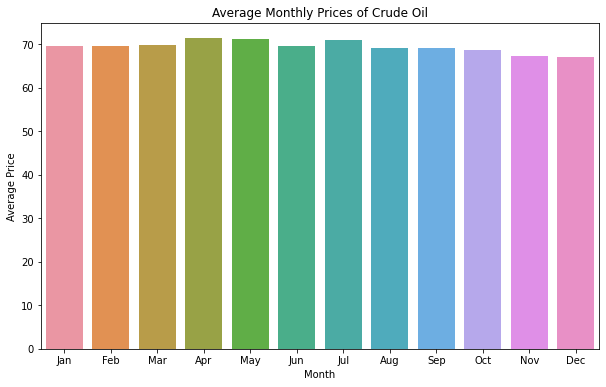

In [29]:
# Extract month from the date index
commodity_data['Month'] = commodity_data.index.month

# Calculate average price for each month over the years
monthly_avg = commodity_data.groupby('Month')['Close'].mean()

# Plot the average monthly prices
plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_avg.index, y=monthly_avg.values)
plt.title('Average Monthly Prices of Crude Oil')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


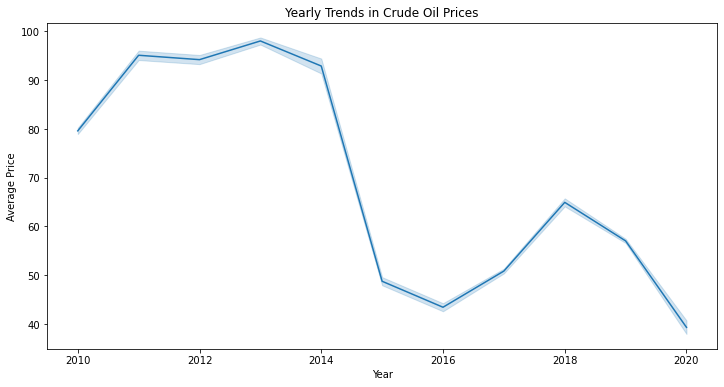

In [30]:
# Extract year from the date index
commodity_data['Year'] = commodity_data.index.year

# Plot yearly trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=commodity_data, x='Year', y='Close', estimator='mean')
plt.title('Yearly Trends in Crude Oil Prices')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.show()


In [31]:
# Extract month and year from the date index
commodity_data['Month'] = commodity_data.index.month
commodity_data['Year'] = commodity_data.index.year

# Group by month and calculate average prices
monthly_avg_prices = commodity_data.groupby('Month')['Close'].mean()


In [32]:
# Number of months to consider for high and low prices
num_months = 3

# Identify months with the highest average prices
higher_price_months = monthly_avg_prices.nlargest(num_months).index.tolist()

# Identify months with the lowest average prices
lower_price_months = monthly_avg_prices.nsmallest(num_months).index.tolist()

print(f"Months with historically higher prices: {higher_price_months}")
print(f"Months with historically lower prices: {lower_price_months}")


Months with historically higher prices: [4, 5, 7]
Months with historically lower prices: [12, 11, 10]


In [33]:
def formulate_strategy(commodity_data):
    # Calculate the rolling average over a multi-year period for each month
    window_size = 5 * 12  # 5 years
    commodity_data['Month'] = commodity_data.index.month
    rolling_avg_prices = commodity_data.groupby('Month')['Close'].rolling(window=window_size).mean().reset_index(level=0, drop=True)
    commodity_data['RollingAvg'] = rolling_avg_prices
    
    buy_threshold = 0.95  # Buy if current price is 95% of the rolling average
    sell_threshold = 1.05  # Sell if current price is 105% of the rolling average

    commodity_data['Signal'] = 0  # Default 'No Action'
    commodity_data['Signal'][commodity_data['Close'] < commodity_data['RollingAvg'] * buy_threshold] = 1  # Buy
    commodity_data['Signal'][commodity_data['Close'] > commodity_data['RollingAvg'] * sell_threshold] = -1  # Sell
    
    last_signal = 0
    for i in range(len(commodity_data)):
        if commodity_data['Signal'].iloc[i] == 1 and last_signal != 1:
            last_signal = 1
        elif commodity_data['Signal'].iloc[i] == -1 and last_signal != -1:
            last_signal = -1
        else:
            commodity_data['Signal'].iloc[i] = 0



    
    return commodity_data


commodity_data = formulate_strategy(commodity_data)

# Displaying the first few signals
print(commodity_data[['Close', 'Signal']].head(20))


C:\Users\MSI\AppData\Local\Temp\ipykernel_37140\400858785.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commodity_data['Signal'][commodity_data['Close'] < commodity_data['RollingAvg'] * buy_threshold] = 1  # Buy
C:\Users\MSI\AppData\Local\Temp\ipykernel_37140\400858785.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commodity_data['Signal'][commodity_data['Close'] > commodity_data['RollingAvg'] * sell_threshold] = -1  # Sell
C:\Users\MSI\AppData\Local\Temp\ipykernel_37140\400858785.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docum

                Close  Signal
Date                         
2010-01-04  81.510002       0
2010-01-05  81.769997       0
2010-01-06  83.180000       0
2010-01-07  82.660004       0
2010-01-08  82.750000       0
2010-01-11  82.519997       0
2010-01-12  80.790001       0
2010-01-13  79.650002       0
2010-01-14  79.389999       0
2010-01-15  78.000000       0
2010-01-19  79.019997       0
2010-01-20  77.620003       0
2010-01-21  76.080002       0
2010-01-22  74.540001       0
2010-01-25  75.260002       0
2010-01-26  74.709999       0
2010-01-27  73.669998       0
2010-01-28  73.639999       0
2010-01-29  72.889999       0
2010-02-01  74.430000       0


In [34]:
stop_loss_percentage = 0.05  # Example: 5% stop loss
take_profit_percentage = 0.10  # Example: 10% take profit


In [35]:
# Months with historically higher and lower prices (obtained from previous analysis)
#higher_price_months = [5, 6, 7]  # Example months
#lower_price_months = [11, 12, 1]  # Example months

# Create buy and sell signals
commodity_data['Signal'] = 0  # No position
commodity_data['Signal'][commodity_data.index.month.isin(lower_price_months)] = 1  # Buy
commodity_data['Signal'][commodity_data.index.month.isin(higher_price_months)] = -1  # Sell


C:\Users\MSI\AppData\Local\Temp\ipykernel_37140\943265741.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commodity_data['Signal'][commodity_data.index.month.isin(lower_price_months)] = 1  # Buy
C:\Users\MSI\AppData\Local\Temp\ipykernel_37140\943265741.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commodity_data['Signal'][commodity_data.index.month.isin(higher_price_months)] = -1  # Sell


In [51]:
initial_capital = 100000
commodity_data['Holdings'] = 0
commodity_data['Capital'] = initial_capital


for i in range(1, len(commodity_data)):
    # Buy
    if commodity_data['Signal'].iloc[i] == 1 and commodity_data['Holdings'].iloc[i-1] == 0:  
        commodity_data['Holdings'].iloc[i] = initial_capital / commodity_data['Close'].iloc[i]  
        commodity_data['Capital'].iloc[i] = 0  
    # Sell
    elif commodity_data['Signal'].iloc[i] == -1 and commodity_data['Holdings'].iloc[i-1] > 0:  
        commodity_data['Capital'].iloc[i] = commodity_data['Holdings'].iloc[i-1] * commodity_data['Close'].iloc[i]  
        commodity_data['Holdings'].iloc[i] = 0
    # No action, carry forward the values
    else:  
        commodity_data['Holdings'].iloc[i] = commodity_data['Holdings'].iloc[i-1]
        commodity_data['Capital'].iloc[i] = commodity_data['Capital'].iloc[i-1]

        
commodity_data['Total Value'] = commodity_data['Capital'] + commodity_data['Holdings'] * commodity_data['Close']
commodity_data['Returns'] = commodity_data['Total Value'].pct_change()


C:\Users\MSI\AppData\Local\Temp\ipykernel_37140\2966679170.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commodity_data['Holdings'].iloc[i] = commodity_data['Holdings'].iloc[i-1]
C:\Users\MSI\AppData\Local\Temp\ipykernel_37140\2966679170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commodity_data['Capital'].iloc[i] = commodity_data['Capital'].iloc[i-1]
C:\Users\MSI\AppData\Local\Temp\ipykernel_37140\2966679170.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [52]:
total_return = commodity_data['Total Value'][-1] - initial_capital
annualized_return = np.power(commodity_data['Total Value'][-1] / initial_capital, 1/len(set(commodity_data.index.year))) - 1
sharpe_ratio = commodity_data['Returns'].mean() / commodity_data['Returns'].std() * np.sqrt(252)

print(f"Total Return: {total_return}")
print(f"Annualized Return: {annualized_return}")
print(f"Sharpe Ratio: {sharpe_ratio}")


Total Return: 25000.0
Annualized Return: 0.02049293216846504
Sharpe Ratio: 0.24054493375557479


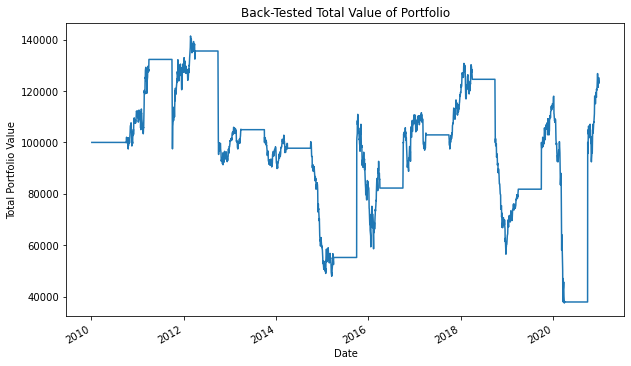

In [53]:
commodity_data['Total Value'].plot(figsize=(10, 6))
plt.title('Back-Tested Total Value of Portfolio')
plt.xlabel('Date')
plt.ylabel('Total Portfolio Value')
plt.show()